In [1]:
# Import 
import os
import time
import json
import datetime
import pandas as pd
import numpy as np

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline

vispy  won't work


In [2]:
import sys
sys.path.append("..")

In [3]:
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.toolbox import modify_some_initial_settings


In [4]:
SIM_DIR = Path('/home/lglepin/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticity'

try:
    sim_save_dir.mkdir(parents=True, exist_ok=True)
except FileExistsError:
    pass

In [5]:


dsets = hdf5.load_datasets('../json_hdf5/super_eggs_polarity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/super_eggs_polarity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs)
modify_some_initial_settings(sheet)
scale_factor = 1 / sheet.face_df.area.mean()**0.5
geom.scale(sheet, scale_factor, list("xyz"))
print(f"scaling factor: {scale_factor}")
geom.update_all(sheet)


scaling factor: 1.6061401200740943


In [6]:
sheet.face_df.area.mean()

1.0

In [7]:
sheet.face_df.prefered_perimeter = 2
sheet.settings["lumen_prefered_vol"] = 5600
sheet.settings["lumen_vol_elasticity"] = 1e-2
sheet.settings["barrier_radius"] = 13 

sheet.face_df["perimeter_elasticity"] = 0.1

# no barrier elasticity
sheet.vert_df["barrier_elasticity"] = 0 # compare

solver = QSSolver(with_t1=False, with_t3=False)

res = solver.find_energy_min(sheet, geom, model, options={"gtol":1e-4})


In [8]:
import ipyvolume as ipv
ipv.clear()

fig, ax = sheet_view(sheet, coords=["z", "x", "y"], mode="3D")
fig

Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.0, position=(0.0,…

In [9]:
sheet.face_df["perimeter_elasticity"]

face
0       0.1
1       0.1
2       0.1
3       0.1
4       0.1
       ... 
1647    0.1
1648    0.1
1649    0.1
1650    0.1
1651    0.1
Name: perimeter_elasticity, Length: 1652, dtype: float64

In [10]:
sheet.settings

{'geometry': 'spherical',
 'height_axis': 'z',
 'lumen_prefered_vol': 5600,
 'lumen_vol_elasticity': 0.01,
 'threshold_length': 0.1,
 'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
 'barrier_radius': 13,
 'apopto_pattern_kwargs': {'t': 0.0,
  'dt': 1.0,
  'time_of_last_apoptosis': 30.0},
 'apoptosis': {'critical_area_pulling': 10,
  'critical_area': 0.5,
  'contract_rate': 1.08,
  'basal_contract_rate': 1.01,
  'contract_neighbors': True,
  'contract_span': 3,
  'radial_tension': 50.0,
  'max_traction': 30.0,
  'current_traction': 0.0,
  'geom': polarity.dynamics.EllipsoidLameGeometry},
 'contraction_lt_kwargs': {'face_id': -1,
  'face': -1,
  'shrink_rate': 1.05,
  'critical_area': 5.0,
  'contraction_column': 'line_tension',
  'model': tyssue.dynamics.factory.model_factory.<locals>.NewModel},
 'delaminate_setting': {'radial_tension': 80,
  'contract_rate': 1.08,
  'critical_area_pulling': 15,
  'critical_area': 0.01,
  'current_traction': 0,
  'max_traction'

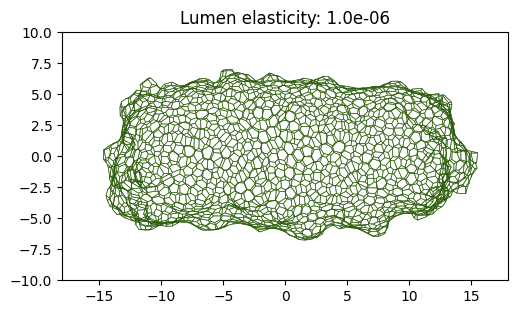

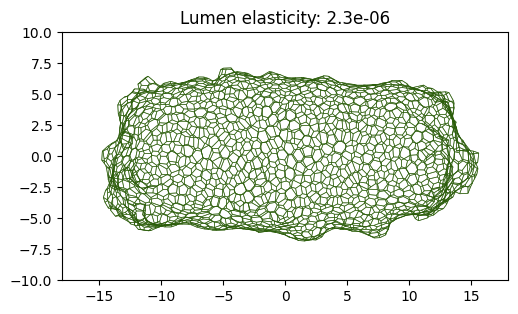

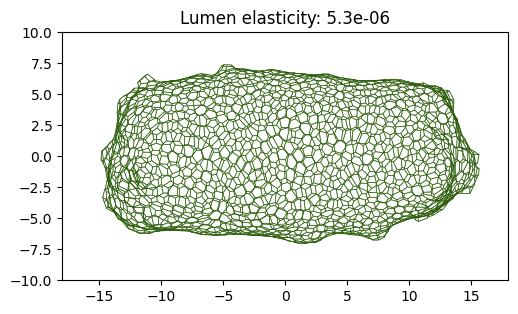

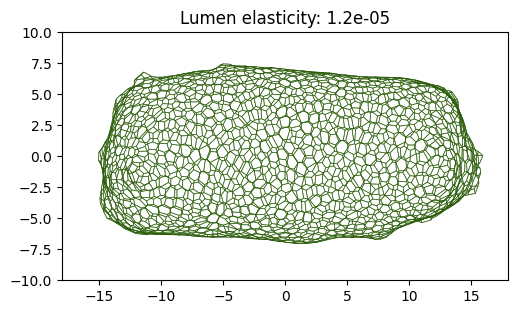

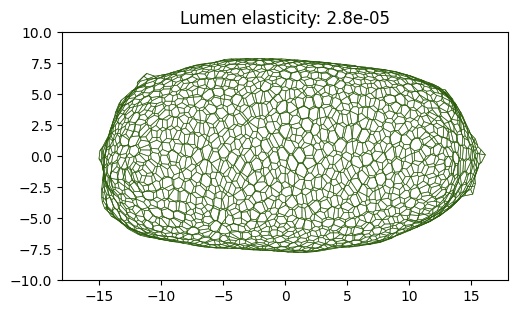

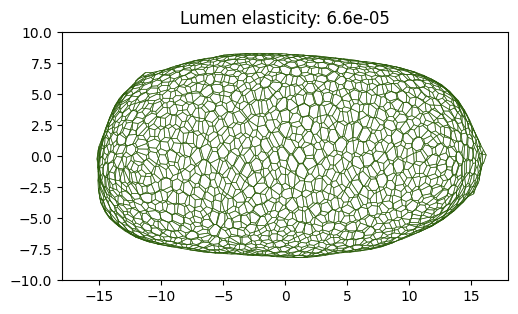

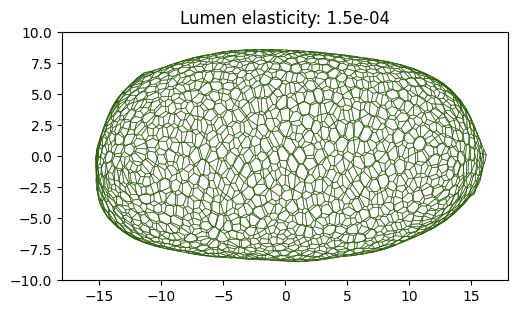

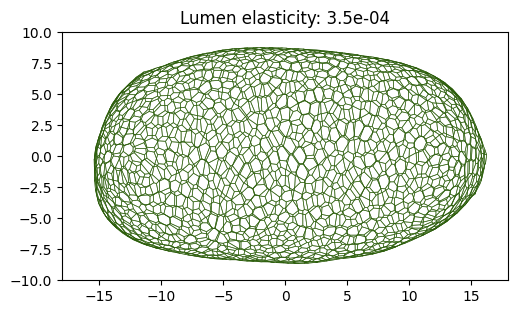

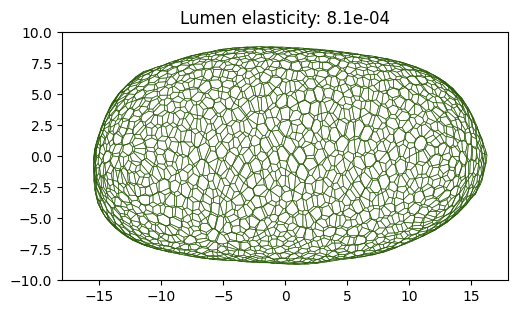

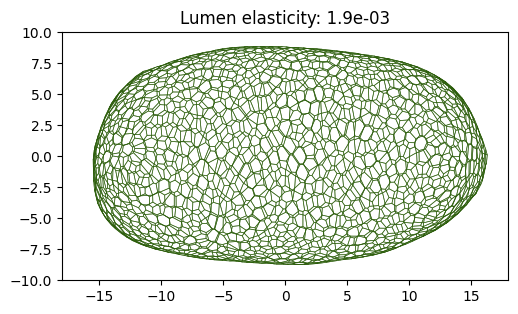

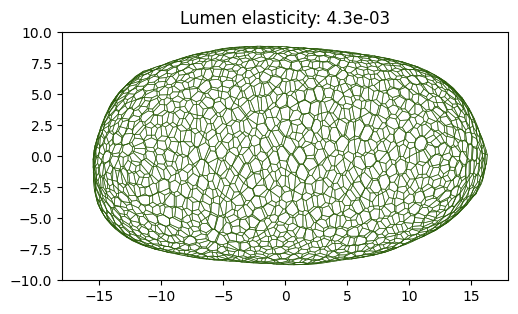

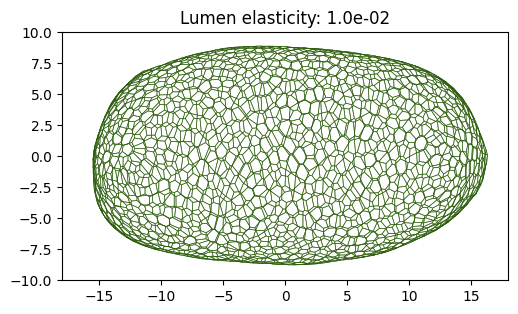

In [11]:
elasticity_values = []
lumen_volume_values = [] 
area_cell_values = []
cell_perimeters = []
diameters = []

elasticity_values = np.logspace(-6, -2, 12)
for value in elasticity_values:
    sheet_copy = sheet.copy()
    # add some position noise to avoid being stuck in a local min
    sheet_copy.vert_df[['x', 'y', 'z']] += np.random.normal(0.0, 1e-3, (sheet.Nv, 3))
    sheet_copy.settings["lumen_vol_elasticity"] = value
    geom.update_all(sheet_copy)
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-4})
    fig, ax = sheet_view(sheet_copy, coords=["z", "x"])
    lumen_volume = sheet_copy.settings["lumen_vol"]
    area_cell = sheet_copy.face_df["area"].mean()
    ax.set_title(f"Lumen elasticity: {value:.1e}")
    ax.set_xlim(-18, 18)
    ax.set_ylim(-10, 10)

    lumen_volume_values.append(lumen_volume)
    length_max = np.percentile(sheet_copy.vert_df["z"], 99)
    length_min = np.percentile(sheet_copy.vert_df["z"], 1)
    diameter = length_max-length_min
    diameters.append(diameter)
    area_cell_values.append(area_cell)
    cell_perimeter = sheet_copy.face_df["perimeter"].mean()
    cell_perimeters.append(cell_perimeter)

lumen_volume_values = np.array(lumen_volume_values)
area_cell_values = np.array(area_cell_values)

In [12]:
sheet.Nf**(3/2) / (6 * np.pi**0.5)

6313.771752082898

In [13]:
elasticity_values

array([1.00000000e-06, 2.31012970e-06, 5.33669923e-06, 1.23284674e-05,
       2.84803587e-05, 6.57933225e-05, 1.51991108e-04, 3.51119173e-04,
       8.11130831e-04, 1.87381742e-03, 4.32876128e-03, 1.00000000e-02])

In [14]:
sheet_copy.face_df.area.mean()

0.9843691548693877

In [15]:
lumen_volume_values

array([2684.97037295, 2926.74953382, 3295.5921393 , 3661.36693274,
       4257.73138142, 4821.54890993, 5196.74999124, 5412.49856525,
       5515.25321878, 5562.37339522, 5582.90792411, 5593.14888458])

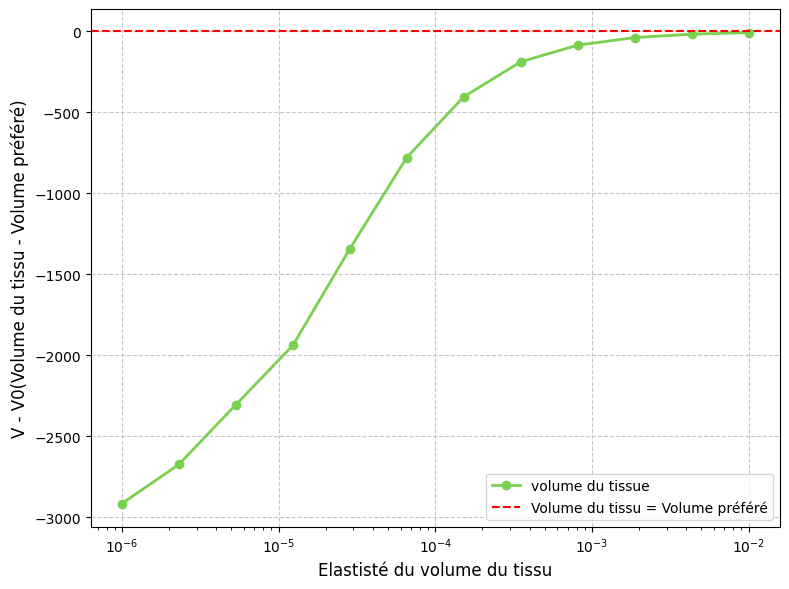

In [34]:
# Generate a list of colors for better visualization
colors = plt.cm.viridis_r([0.2, 0.6])

# Create the plot
fig, axs = plt.subplots(1, figsize=(8, 6))

# Plot lumen_volume_values
axs.plot(elasticity_values, lumen_volume_values-sheet.settings["lumen_prefered_vol"], label='volume du tissue', color=colors[0], marker='o', linestyle='-', linewidth=2)
plt.axhline(y=0 , color='r', linestyle='--', label='Volume du tissu = Volume préféré')
# Set x-axis to logarithmic scale
axs.set_xscale('log')

# Set labels for x and y axes
axs.set_xlabel('Elastisté du volume du tissu', fontsize=12)
axs.set_ylabel('V - V0(Volume du tissu - Volume préféré)', fontsize=12)

# Add a grid for better readability
axs.grid(True, linestyle='--', alpha=0.7)

# Set the legend
axs.legend(loc='best', fontsize=10)

# Tight layout to prevent overlap of labels
plt.tight_layout()
plt.savefig('../image/lumen_vol_elasticity_lumen.png', transparent=True)
# Show the plot
plt.show()


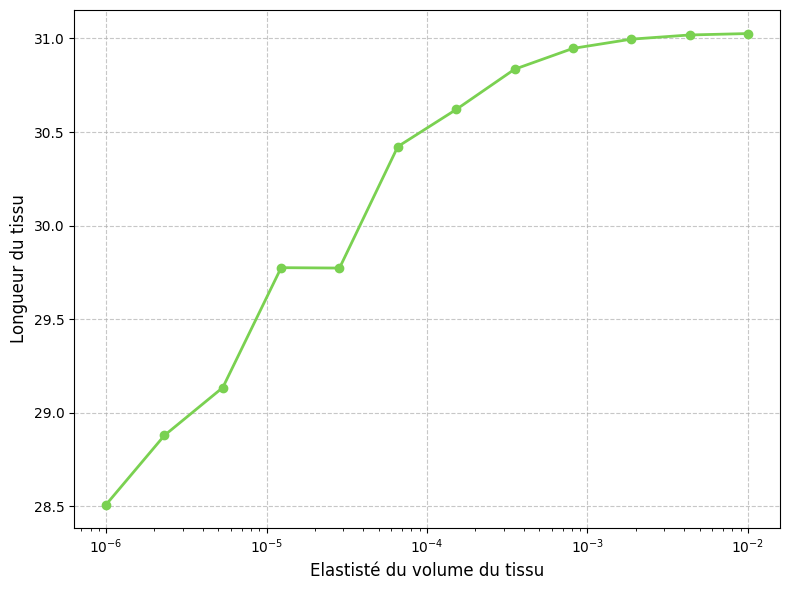

In [17]:
# Generate a list of colors for better visualization
colors = plt.cm.viridis_r([0.2, 0.6])

# Create the plot
fig, axs = plt.subplots(1, figsize=(8, 6))

# Plot lumen_volume_values
axs.plot(elasticity_values, diameters, color=colors[0], marker='o', linestyle='-', linewidth=2)
# Set x-axis to logarithmic scale
axs.set_xscale('log')

# Set labels for x and y axes
axs.set_xlabel('Elastisté du volume du tissu', fontsize=12)
axs.set_ylabel('Longueur du tissu', fontsize=12)

# Add a grid for better readability
axs.grid(True, linestyle='--', alpha=0.7)

# Set the legend
#axs.legend(loc='best', fontsize=10)

# Tight layout to prevent overlap of labels
plt.tight_layout()
plt.savefig('../image/lumen_length_elasticity_lumen.png', transparent=False)
# Show the plot
plt.show()

In [18]:
2000 * (2 ** (3/2))


5656.85424949238

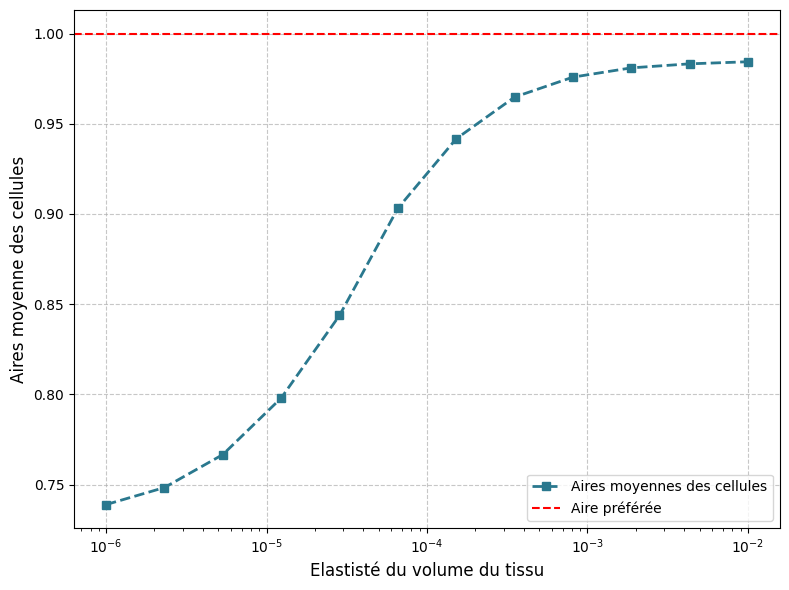

In [19]:
colors = plt.cm.viridis_r([0.2, 0.6])
fig, axs = plt.subplots(1, figsize=(8, 6))
axs.plot(elasticity_values, area_cell_values, label='Aires moyennes des cellules', color=colors[1], marker='s', linestyle='--', linewidth=2)
plt.axhline(y=1.00, color='r', linestyle='--', label='Aire préférée')
axs.set_xscale('log')
axs.set_xlabel('Elastisté du volume du tissu', fontsize=12)
axs.set_ylabel('Aires moyenne des cellules', fontsize=12)
axs.grid(True, linestyle='--', alpha=0.7)
axs.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../image/area_cell_elasticity_lumen.png', transparent=True)
plt.show()

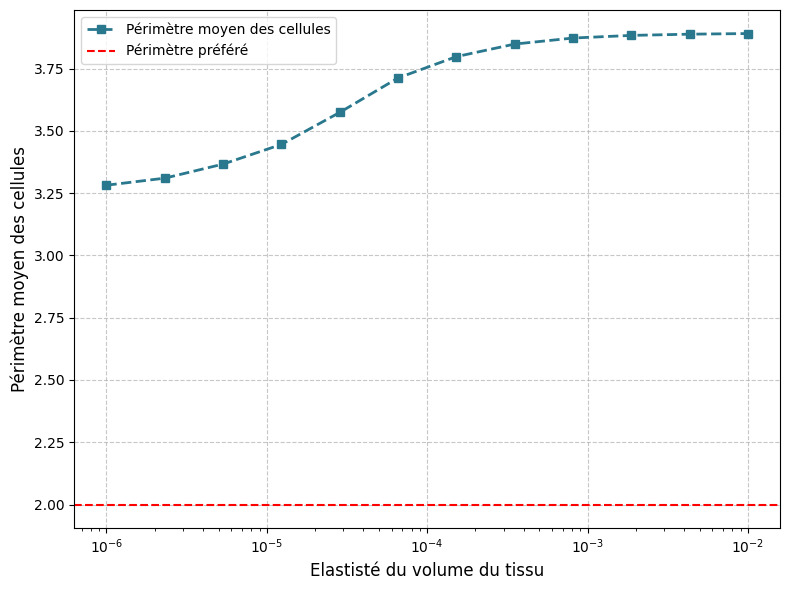

In [20]:
colors = plt.cm.viridis_r([0.2, 0.6])
fig, axs = plt.subplots(1, figsize=(8, 6))
axs.plot(elasticity_values, cell_perimeters, label='Périmètre moyen des cellules', color=colors[1], marker='s', linestyle='--', linewidth=2)
plt.axhline(y=2.0, color='r', linestyle='--', label='Périmètre préféré')
axs.set_xscale('log')
axs.set_xlabel('Elastisté du volume du tissu', fontsize=12)
axs.set_ylabel('Périmètre moyen des cellules', fontsize=12)
axs.grid(True, linestyle='--', alpha=0.7)
axs.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../image/cell_perimeters_elasticity_lumen.png', transparent=False)
plt.show()

In [21]:
print (lumen_volume_values)

[2684.97037295 2926.74953382 3295.5921393  3661.36693274 4257.73138142
 4821.54890993 5196.74999124 5412.49856525 5515.25321878 5562.37339522
 5582.90792411 5593.14888458]


In [22]:
specs['vert'] = {"toto": 280}
sheet.update_specs(specs, reset=True)

In [23]:
specs

{'face': {'prefered_perimeter': 2},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5600,
  'lumen_vol_elasticity': 0.001,
  'threshold_length': 0.1,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 100},
 'vert': {'toto': 280}}

In [24]:
sheet.face_df.prefered_perimeter = 2
sheet.settings["lumen_prefered_vol"] = 5600
sheet.settings["lumen_vol_elasticity"] = 1e-2
sheet.face_df["perimeter_elasticity"] = 0.1

In [25]:
specs = {'face': {'prefered_perimeter': 2.0, "perimeter_elasticity": 0.1},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5600,
  'lumen_vol_elasticity': 1e-4,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 100},
 'vert': {'barrier_elasticity': 280}}

In [26]:
sheet.update_specs(specs, reset=True)
res = solver.find_energy_min(sheet, geom, model, options={"gtol":1e-4})


In [27]:
specs

{'face': {'prefered_perimeter': 2.0, 'perimeter_elasticity': 0.1},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5600,
  'lumen_vol_elasticity': 0.0001,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 100},
 'vert': {'barrier_elasticity': 280}}

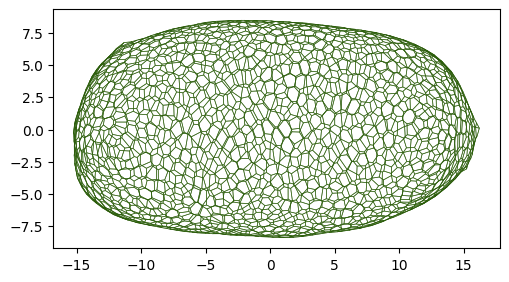

In [28]:
Sheet_ellips = sheet_view(sheet, coords=["z", "x"])

In [29]:
from tyssue.io.hdf5 import save_datasets
save_datasets("../json_hdf5/lumen_elasticity.hdf5", sheet)
from tyssue.config.json_parser import save_spec
save_spec(specs, "../json_hdf5/lumen_elasticity.json", overwrite=True)